In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
import keras.backend as K

In [12]:
max_label_len = 0
char_list = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 
print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
    return dig_lst

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 62


In [13]:
image_path = "test/test1.jpg"


In [14]:
#nosie removed
def line_removal(img):
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,3))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,10))
    rows = []
    col = []
    gray = img
    value,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    horizontal_th, horizontal_dst = cv2.threshold(gray, value+10, 255, cv2.THRESH_BINARY_INV)
    vertical_th, vertical_dst = cv2.threshold(gray, value, 255, cv2.THRESH_BINARY_INV)
    horizontal_lines = cv2.dilate(horizontal_dst, horizontal_kernel , iterations=1)
    vertical_lines = cv2.dilate(vertical_dst, vertical_kernel , iterations=1)
    row,column = thresh.shape
    for i in range(row):
        if np.all(horizontal_lines[i]==255):
            rows.append(i)

    for i in range(column):
        if np.all(vertical_lines[:,i]==255):
            col.append(i)

    copy_col = col[:]
    count = 0
    first = -1
    for i in range(len(copy_col)):
        if i-1<0:
            continue
        elif copy_col[i]-1 == copy_col[i-1]:
            
            if first == -1:
                first = i-1
            count = count+1
        else:
            if count>=20:
                del col[first:i]
            count = 0
            first = -1
    if count>=20:
        del col[first:i+1]
    count = 0
    for i in range(len(col)):
        thresh = np.delete(thresh,col[i]-count,1)
        count = count+1
    count = 0
    for i in range(len(rows)):
        thresh = np.delete(thresh,rows[i]-count,0)
        count = count+1
    thresh = cv2.bitwise_not(thresh)

    return thresh

In [15]:
#image preprocessing
def process_image(img):

    w, h = img.shape
    
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

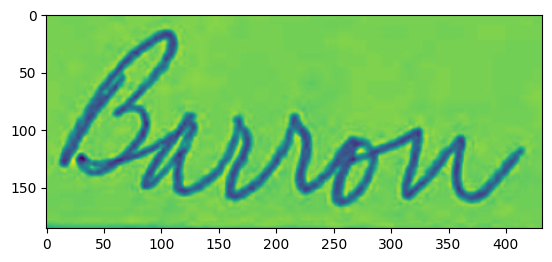

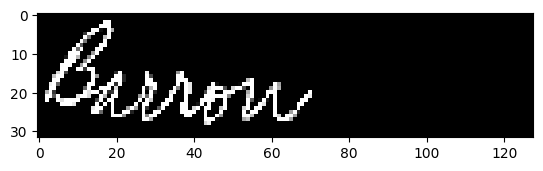

(1, 32, 128, 1)

In [16]:
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.show()
img = line_removal(img)
img = process_image(img)
test = []
test.append(img)
plt.imshow(test[0].reshape(32,128), cmap=plt.cm.gray)
plt.show()
test = np.asarray(test)
test.shape


In [17]:
#model location
main_model_file_path = 'Model/19_OCT_Main_SGD.hdf5'
act_model_file_path = "Model/19_OCT_act.hdf5"

In [18]:
#load the model architecture
act_model = load_model(act_model_file_path,compile = False)

In [19]:
#load the weights from main model to act model.
act_model.load_weights(main_model_file_path)

predicted text = Barronn

prediction Confidence = 0.9114836709839957


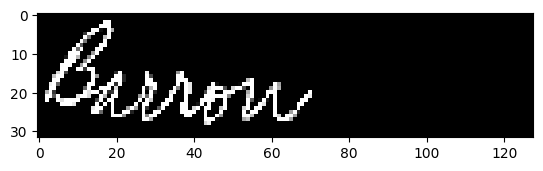

In [20]:
prediction =act_model.predict(test)

# use CTC decoder for decode the labels.
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

pred_cnf = []
for i, x in enumerate(out):
    
    print("predicted text = ", end = '')
    for j,p in enumerate (x):
        if int(p) != -1:
            print(char_list[int(p)],end = '')
            pred_cnf.append(max(prediction[0][j]))
    print('\n')
    print( f"prediction Confidence = {sum(pred_cnf)/len(pred_cnf)}" )
    plt.imshow(img.reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')